In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy import stats

In [2]:
sp500 = pd.read_csv('weekly sp500 Trading Strategy v2.csv')
sp500.head(10)

,TICKER,date,SICCD,COMNAM,market_cap,SHROUT,VOL,PRC,ASKHI,BIDLO,...,comp_size,dummy_negative,dummy_positive,dummy_total,move_avg_2,move_avg_3,move_avg_4,lasso_pred,pred_forest,log_pred
0,A,2023-01-30,3825,AGILENT TECHNOLOGIES INC,1.882646,0.867158,-1.498350,1.881778,1.880254,1.862643,...,6,0,0,1,1,1,1,-0.005843,-0.019319,Negative
1,A,2023-02-06,3825,AGILENT TECHNOLOGIES INC,1.809625,0.867158,-0.740216,1.807475,1.796901,1.815199,...,6,0,0,1,1,1,1,-0.010486,0.006706,Negative
2,A,2023-02-13,3825,AGILENT TECHNOLOGIES INC,1.790852,0.867158,-1.422238,1.788372,1.728162,1.876098,...,6,0,0,1,1,1,1,-0.008617,-0.019308,Negative
3,A,2023-02-20,3825,AGILENT TECHNOLOGIES INC,1.558986,0.867158,-1.321756,1.552434,1.688534,1.551775,...,6,0,0,1,1,1,1,-0.007347,-0.036732,Negative
4,A,2023-02-27,3825,AGILENT TECHNOLOGIES INC,1.012605,0.867158,-0.548320,0.996459,1.056445,1.001558,...,6,0,1,1,1,1,1,-0.004766,0.017838,Negative
5,A,2023-03-06,3825,AGILENT TECHNOLOGIES INC,0.960566,0.867158,0.138736,0.943505,0.972051,0.814611,...,6,0,0,1,1,1,1,-0.006981,-0.043131,Negative
6,A,2023-03-13,3825,AGILENT TECHNOLOGIES INC,0.743297,0.867158,-0.662707,0.722421,0.848757,0.717598,...,6,0,1,1,1,1,1,0.000798,0.030798,Positive
7,A,2023-03-20,3826,AGILENT TECHNOLOGIES INC,0.527961,0.867158,-0.139099,0.503304,0.566746,0.539857,...,6,0,1,1,1,1,1,-0.005700,0.005021,Negative
8,A,2023-03-27,3826,AGILENT TECHNOLOGIES INC,0.388959,0.867158,-0.160573,0.361861,0.423308,0.258021,...,6,0,1,1,1,1,1,-0.004367,0.046274,Negative
9,A,2023-04-03,3826,AGILENT TECHNOLOGIES INC,0.525957,0.759323,-0.555920,0.506113,0.506314,0.526459,...,6,0,0,1,0,1,1,-0.008864,-0.028568,Negative


In [3]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23177 entries, 0 to 23176
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TICKER            23177 non-null  object 
 1   date              23177 non-null  object 
 2   SICCD             23177 non-null  int64  
 3   COMNAM            23177 non-null  object 
 4   market_cap        23177 non-null  float64
 5   SHROUT            23177 non-null  float64
 6   VOL               23177 non-null  float64
 7   PRC               23177 non-null  float64
 8   ASKHI             23177 non-null  float64
 9   BIDLO             23177 non-null  float64
 10  total             23177 non-null  int64  
 11  negative          23177 non-null  int64  
 12  positive          23177 non-null  int64  
 13  sprtrn            23177 non-null  float64
 14  RET               23177 non-null  float64
 15  next_week_return  23177 non-null  float64
 16  last_week_return  23177 non-null  float6

In [4]:
# Change date column to datetime with %Y-%m-%d format
sp500['date'] = pd.to_datetime(sp500['date'], format='%Y-%m-%d')

# Change SICCD column to object
sp500['SICCD'] = sp500['SICCD'].astype(str)

# Change proper. column to object
sp500['proper'] = sp500['proper'].astype(str)

# Print the updated DataFrame info to verify the changes
print(sp500.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23177 entries, 0 to 23176
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   TICKER            23177 non-null  object        
 1   date              23177 non-null  datetime64[ns]
 2   SICCD             23177 non-null  object        
 3   COMNAM            23177 non-null  object        
 4   market_cap        23177 non-null  float64       
 5   SHROUT            23177 non-null  float64       
 6   VOL               23177 non-null  float64       
 7   PRC               23177 non-null  float64       
 8   ASKHI             23177 non-null  float64       
 9   BIDLO             23177 non-null  float64       
 10  total             23177 non-null  int64         
 11  negative          23177 non-null  int64         
 12  positive          23177 non-null  int64         
 13  sprtrn            23177 non-null  float64       
 14  RET               2317

In [5]:
import pandas as pd
from scipy.stats import ttest_ind

# Drop rows with NaN values in 'next_week_return' column
sp500.dropna(subset=['next_week_return'], inplace=True)

# Select only numeric columns
numeric_columns = sp500.select_dtypes(include=['int64', 'float64'])

# Create subsets
positive_return = numeric_columns[sp500['next_week_return'] >= 0]
negative_return = numeric_columns[sp500['next_week_return'] < 0]

# Calculate mean for each subset
mean_positive_return = positive_return.mean()
mean_negative_return = negative_return.mean()

# Calculate mean difference
mean_diff = mean_positive_return - mean_negative_return

# Perform t-test for mean difference
t_stat, p_value = ttest_ind(positive_return, negative_return, equal_var=False)

# Create a DataFrame to store the results
result_df = pd.DataFrame(index=numeric_columns.columns)
result_df['negative_next_week_return'] = mean_negative_return
result_df['mean_positive_next_week_return'] = mean_positive_return
result_df['mean_difference'] = mean_diff
result_df['p_value'] = p_value

# Set pandas display options to suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Print the result DataFrame
print(result_df)

                  negative_next_week_return  mean_positive_next_week_return  \
market_cap                            0.138                          -0.151   
SHROUT                                0.017                          -0.021   
VOL                                   0.001                           0.042   
PRC                                   0.137                          -0.148   
ASKHI                                 0.136                          -0.145   
BIDLO                                 0.132                          -0.143   
total                                 1.549                           1.479   
negative                              0.012                           0.010   
positive                              0.184                           0.182   
sprtrn                               -0.018                          -0.054   
RET                                   0.000                          -0.039   
next_week_return                     -0.029         

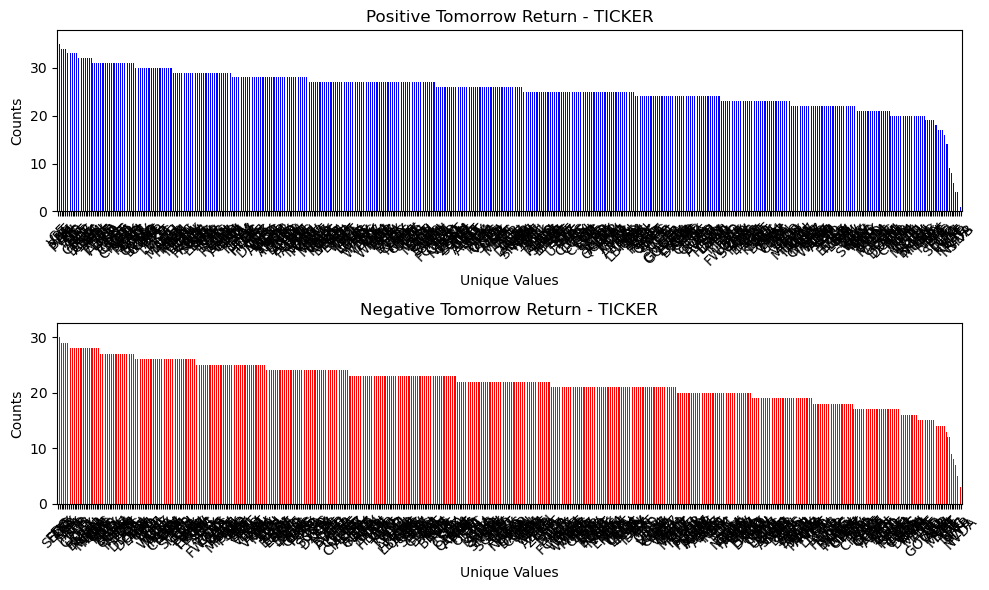

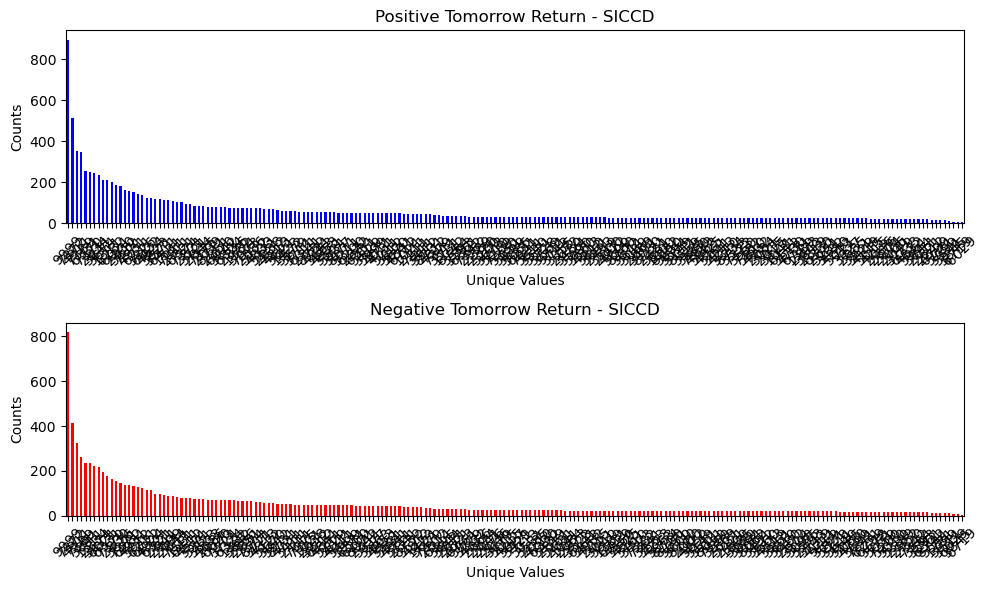

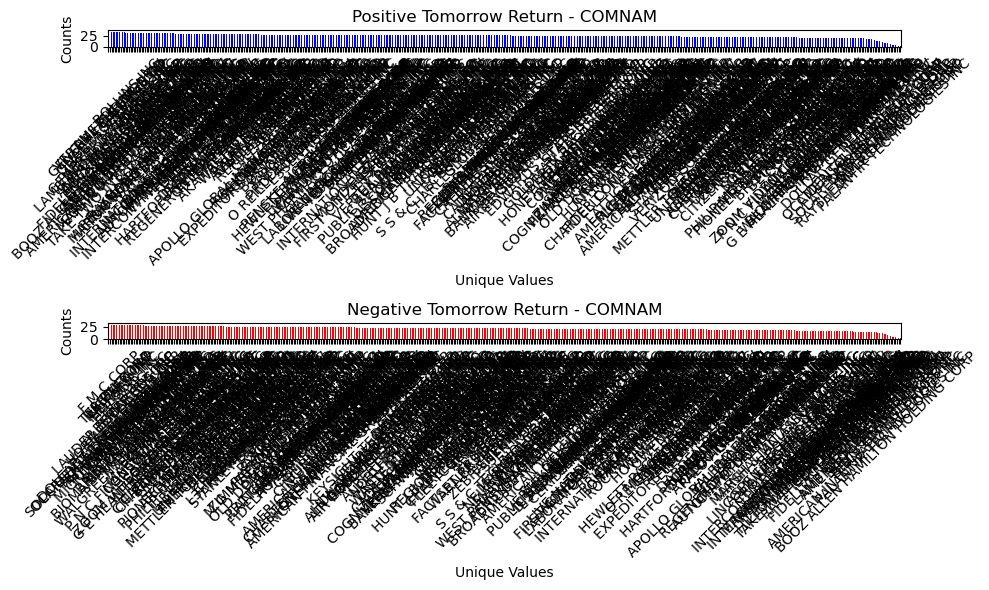

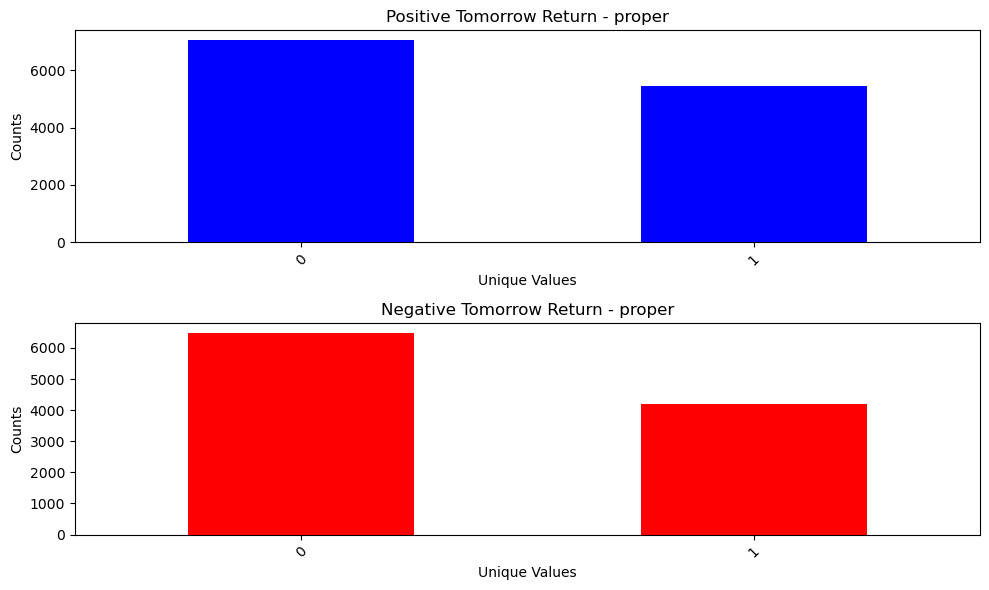

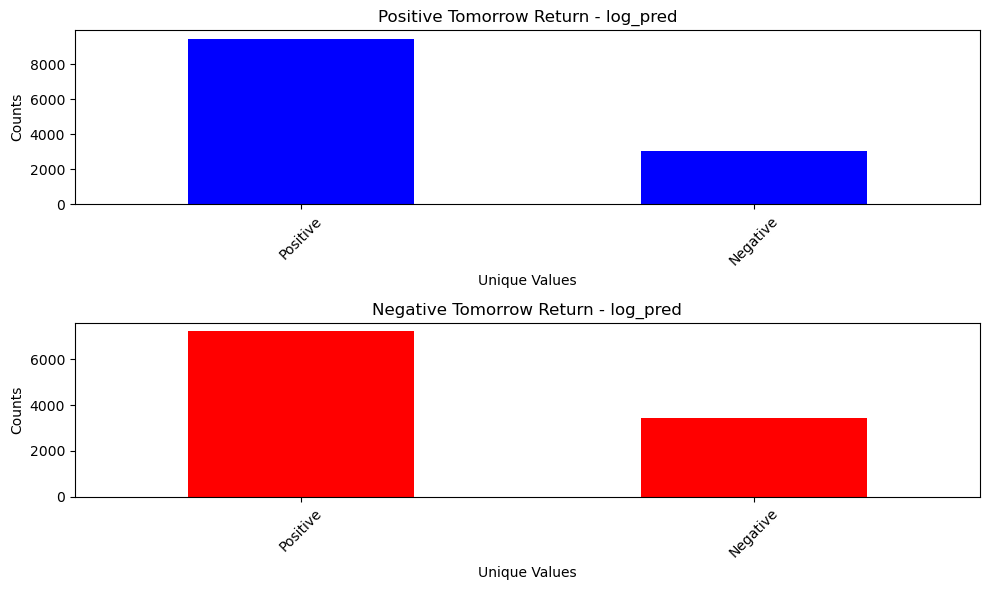

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Drop rows with NaN values in 'next_week_return' column
sp500.dropna(subset=['next_week_return'], inplace=True)

# Select only categorical columns
categorical_columns = sp500.select_dtypes(include=['object'])

# Create subsets
positive_return = sp500[sp500['next_week_return'] >= 0]
negative_return = sp500[sp500['next_week_return'] < 0]

# Plot bar charts for each unique value in categorical columns
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    
    # Positive return subset
    plt.subplot(2, 1, 1)
    positive_counts = positive_return[column].value_counts()
    positive_counts.plot(kind='bar', color='blue')
    plt.title(f'Positive Tomorrow Return - {column}')
    plt.xlabel('Unique Values')
    plt.ylabel('Counts')
    plt.xticks(rotation=45)
    
    # Negative return subset
    plt.subplot(2, 1, 2)
    negative_counts = negative_return[column].value_counts()
    negative_counts.plot(kind='bar', color='red')
    plt.title(f'Negative Tomorrow Return - {column}')
    plt.xlabel('Unique Values')
    plt.ylabel('Counts')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

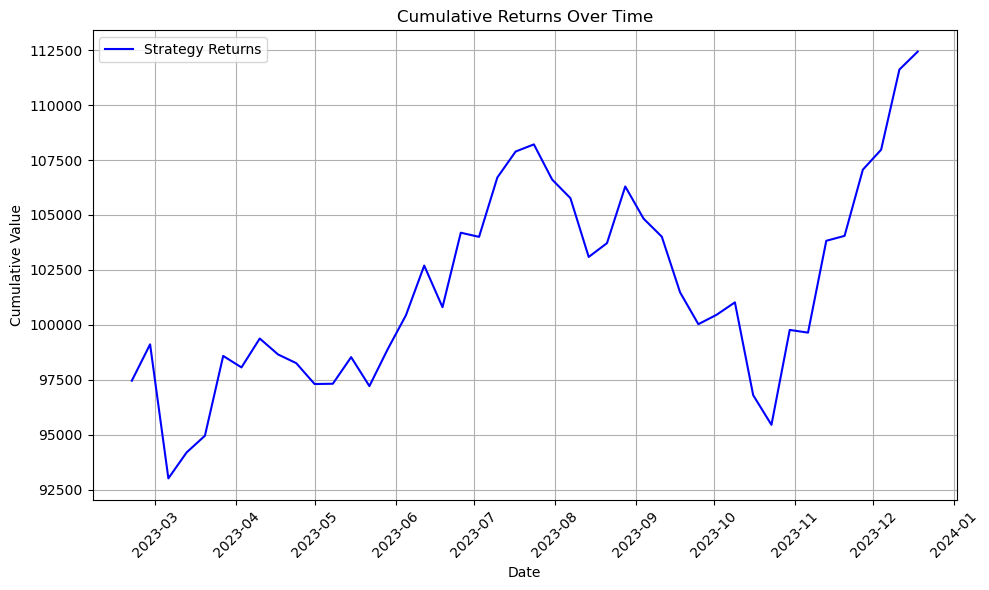

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
sp500_copy = sp500.copy()

# Convert 'date' column to datetime format
sp500_copy['date'] = pd.to_datetime(sp500_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
sp500_copy = sp500_copy[sp500_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
sp500_copy.loc[(sp500_copy['dummy_total'] == 1), 'position'] = 1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = sp500_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = sp500_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = sp500_copy[sp500_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


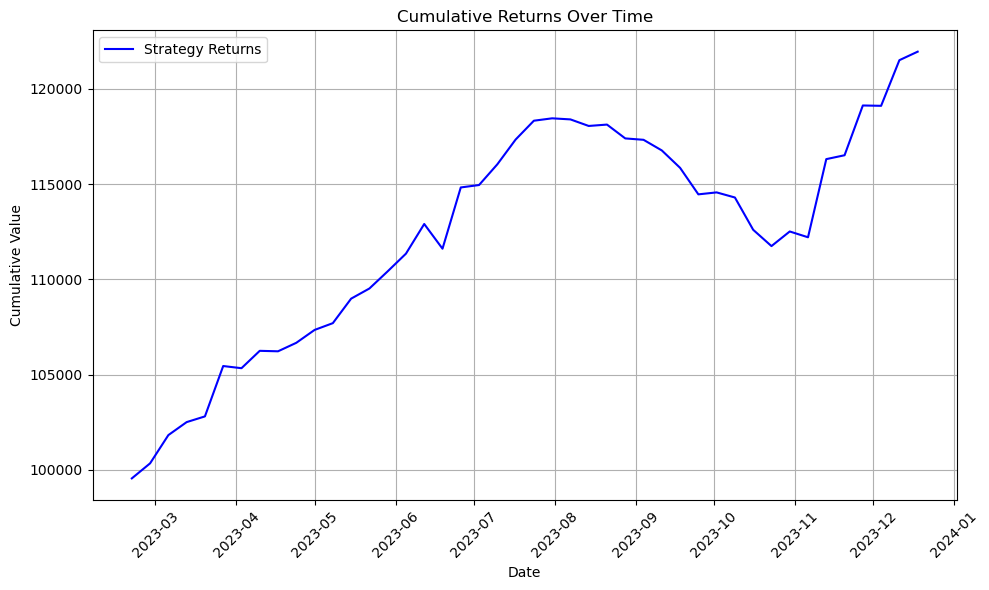

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
sp500_copy = sp500.copy()

# Convert 'date' column to datetime format
sp500_copy['date'] = pd.to_datetime(sp500_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
sp500_copy = sp500_copy[sp500_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
sp500_copy['position'] = 0
sp500_copy.loc[(sp500_copy['lasso_pred'] > 0), 'position'] = 1
sp500_copy.loc[(sp500_copy['lasso_pred'] < 0), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = sp500_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = sp500_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = sp500_copy[sp500_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


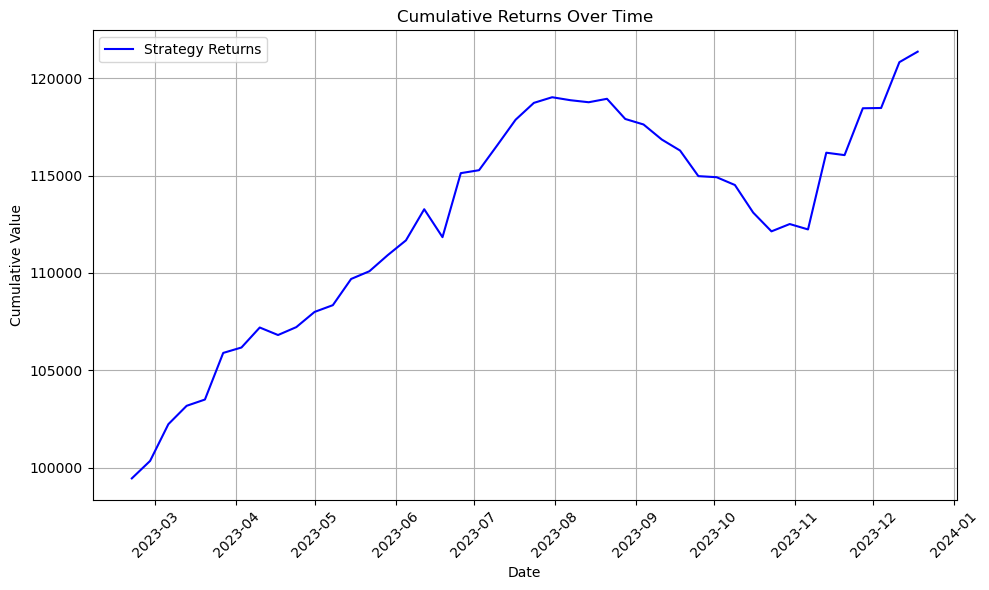

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
sp500_copy = sp500.copy()

# Convert 'date' column to datetime format
sp500_copy['date'] = pd.to_datetime(sp500_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
sp500_copy = sp500_copy[sp500_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
sp500_copy['position'] = 0
sp500_copy.loc[(sp500_copy['lasso_pred'] > 0) & (sp500_copy['dummy_total'] == 1), 'position'] = 1
sp500_copy.loc[(sp500_copy['lasso_pred'] < 0) & (sp500_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = sp500_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = sp500_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = sp500_copy[sp500_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


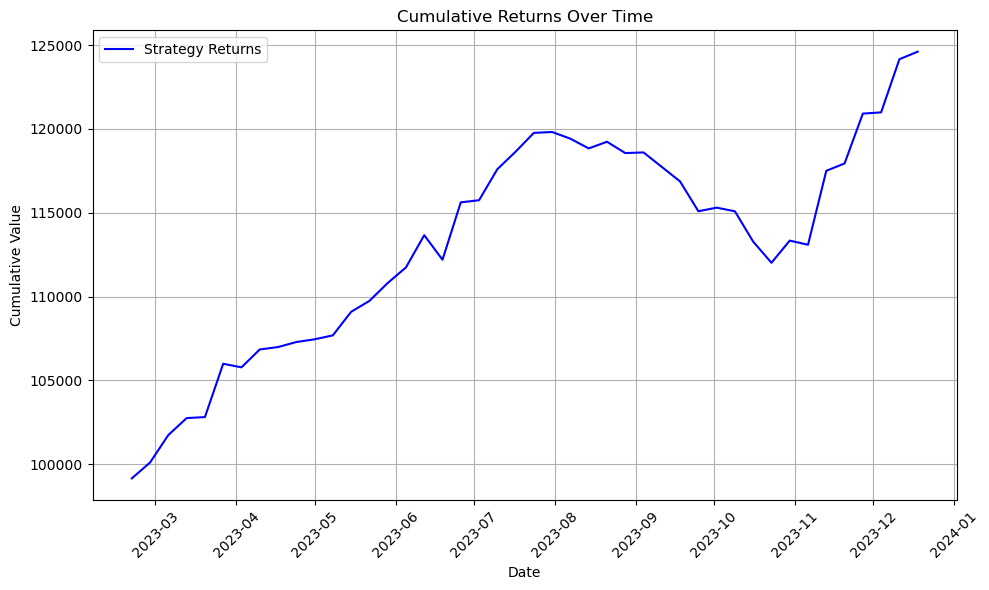

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
sp500_copy = sp500.copy()

# Convert 'date' column to datetime format
sp500_copy['date'] = pd.to_datetime(sp500_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
sp500_copy = sp500_copy[sp500_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
sp500_copy['position'] = 0
sp500_copy.loc[(sp500_copy['log_pred'] == 'Positive'), 'position'] = 1
sp500_copy.loc[(sp500_copy['log_pred'] == 'Negative'), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = sp500_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = sp500_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = sp500_copy[sp500_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


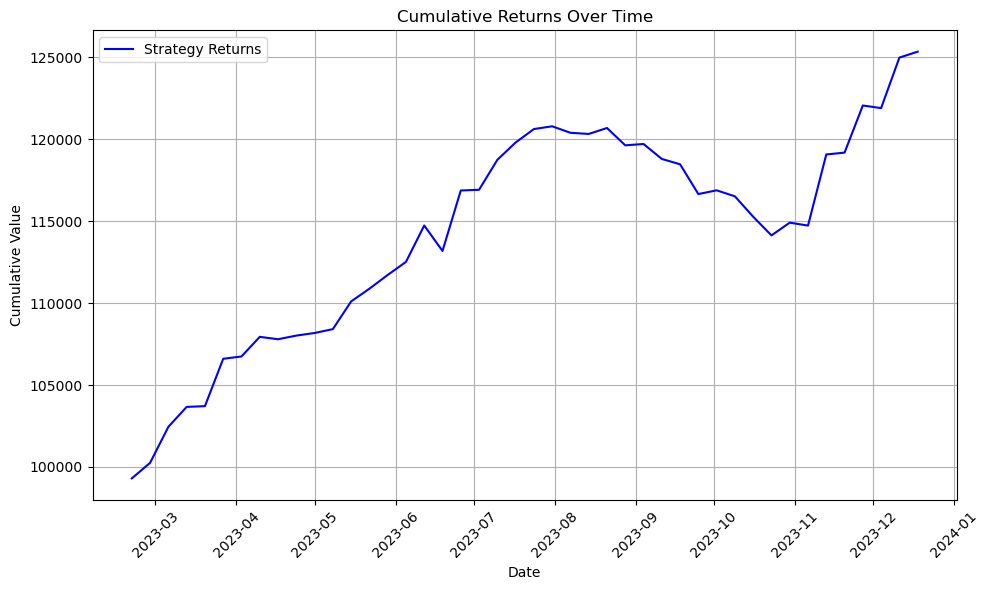

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
sp500_copy = sp500.copy()

# Convert 'date' column to datetime format
sp500_copy['date'] = pd.to_datetime(sp500_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
sp500_copy = sp500_copy[sp500_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
sp500_copy['position'] = 0
sp500_copy.loc[(sp500_copy['log_pred'] == 'Positive') & (sp500_copy['dummy_total'] == 1), 'position'] = 1
sp500_copy.loc[(sp500_copy['log_pred'] == 'Negative') & (sp500_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = sp500_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = sp500_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = sp500_copy[sp500_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


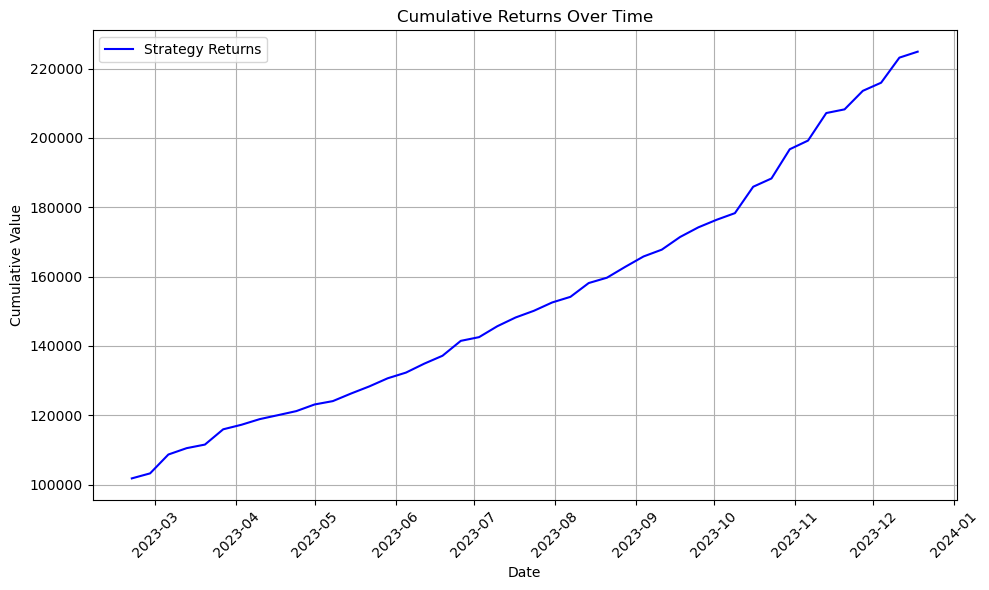

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
sp500_copy = sp500.copy()

# Convert 'date' column to datetime format
sp500_copy['date'] = pd.to_datetime(sp500_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
sp500_copy = sp500_copy[sp500_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
sp500_copy['position'] = 0
sp500_copy.loc[(sp500_copy['pred_forest'] > 0), 'position'] = 1
sp500_copy.loc[(sp500_copy['pred_forest'] < 0), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = sp500_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = sp500_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = sp500_copy[sp500_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


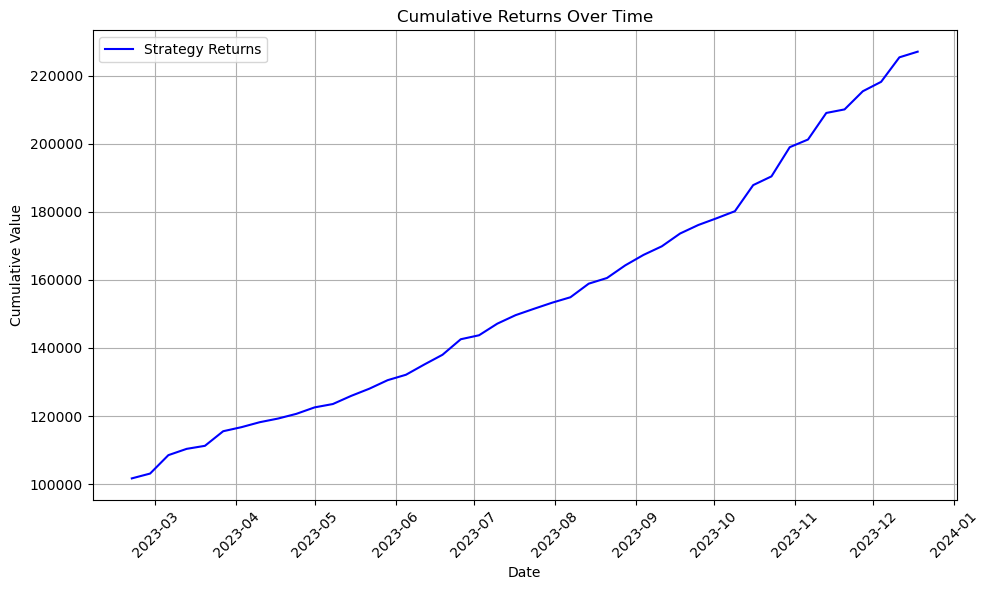

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
sp500_copy = sp500.copy()

# Convert 'date' column to datetime format
sp500_copy['date'] = pd.to_datetime(sp500_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
sp500_copy = sp500_copy[sp500_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
sp500_copy['position'] = 0
sp500_copy.loc[(sp500_copy['pred_forest'] > 0) & (sp500_copy['dummy_total'] == 1), 'position'] = 1
sp500_copy.loc[(sp500_copy['pred_forest'] < 0) & (sp500_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = sp500_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = sp500_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = sp500_copy[sp500_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


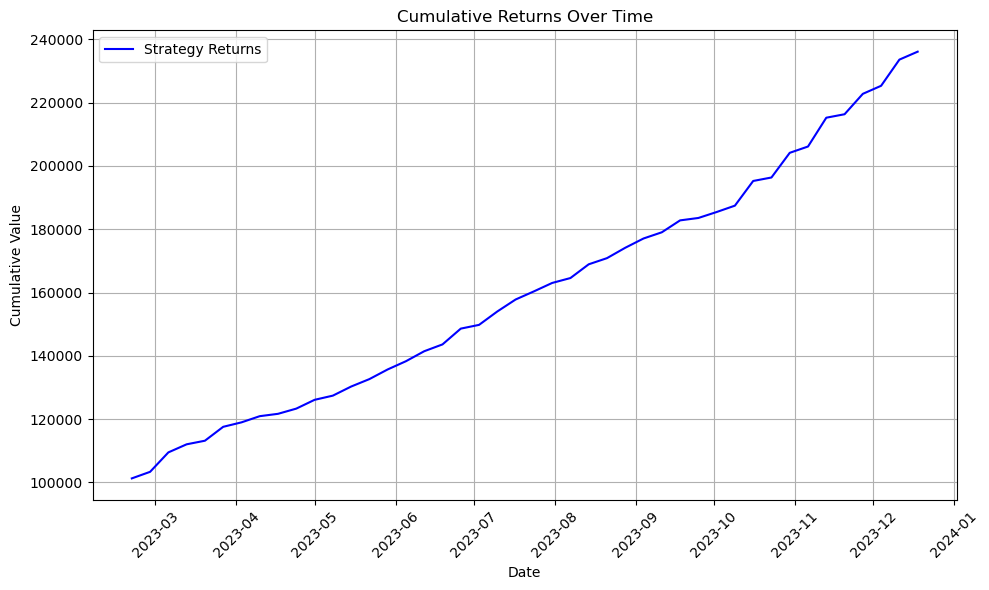

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
sp500_copy = sp500.copy()

# Convert 'date' column to datetime format
sp500_copy['date'] = pd.to_datetime(sp500_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
sp500_copy = sp500_copy[sp500_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
sp500_copy['position'] = 0
sp500_copy.loc[(sp500_copy['pred_forest'] > 0) & (sp500_copy['lasso_pred'] > 0) & (sp500_copy['dummy_total'] == 1), 'position'] = 1
sp500_copy.loc[(sp500_copy['pred_forest'] < 0) & (sp500_copy['lasso_pred'] < 0) & (sp500_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = sp500_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = sp500_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = sp500_copy[sp500_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


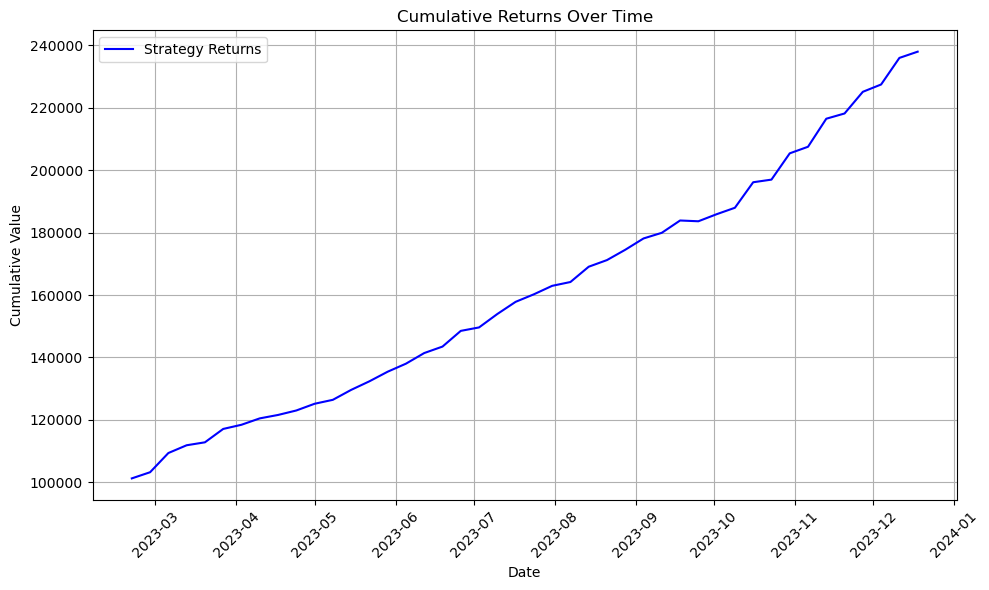

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
sp500_copy = sp500.copy()

# Convert 'date' column to datetime format
sp500_copy['date'] = pd.to_datetime(sp500_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
sp500_copy = sp500_copy[sp500_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
sp500_copy['position'] = 0
sp500_copy.loc[(sp500_copy['pred_forest'] > 0) & (sp500_copy['log_pred'] == 'Positive') & (sp500_copy['dummy_total'] == 1), 'position'] = 1
sp500_copy.loc[(sp500_copy['pred_forest'] < 0) & (sp500_copy['log_pred'] == 'Negative') & (sp500_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = sp500_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = sp500_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = sp500_copy[sp500_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


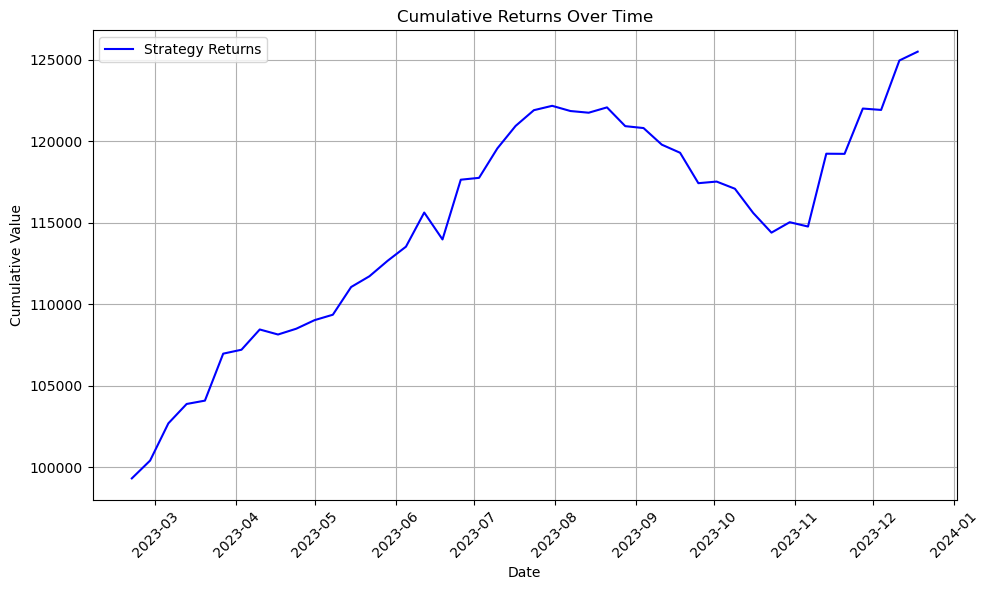

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
sp500_copy = sp500.copy()

# Convert 'date' column to datetime format
sp500_copy['date'] = pd.to_datetime(sp500_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
sp500_copy = sp500_copy[sp500_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
sp500_copy['position'] = 0
sp500_copy.loc[(sp500_copy['log_pred'] == 'Positive') & (sp500_copy['lasso_pred'] > 0) & (sp500_copy['dummy_total'] == 1), 'position'] = 1
sp500_copy.loc[(sp500_copy['log_pred'] == 'Negative') & (sp500_copy['lasso_pred'] < 0) & (sp500_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = sp500_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = sp500_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = sp500_copy[sp500_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


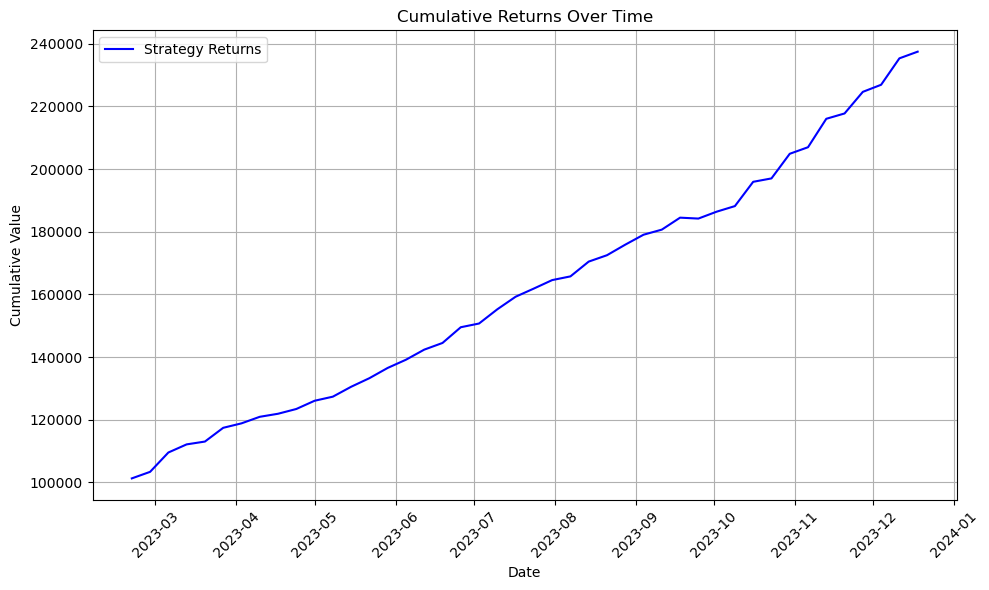

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
sp500_copy = sp500.copy()

# Convert 'date' column to datetime format
sp500_copy['date'] = pd.to_datetime(sp500_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
sp500_copy = sp500_copy[sp500_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
sp500_copy['position'] = 0
sp500_copy.loc[(sp500_copy['pred_forest'] > 0) & (sp500_copy['lasso_pred'] > 0) & (sp500_copy['dummy_total'] == 1) & (sp500_copy['log_pred'] == 'Positive'), 'position'] = 1
sp500_copy.loc[(sp500_copy['pred_forest'] < 0) & (sp500_copy['lasso_pred'] < 0) & (sp500_copy['dummy_total'] == 1) & (sp500_copy['log_pred'] == 'Negative'), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = sp500_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = sp500_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = sp500_copy[sp500_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
